In [1]:
from networks.UNet import LitUNet
from lightning import Trainer
from torch.nn.functional import softmax

In [2]:
import os
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob

In [3]:
from data.dataset import OEMDataset
from torch.utils.data import DataLoader

In [15]:
map_location = {'cuda:0':'cpu'}
ckpt_pth = glob('/home/ubuntu/hrl/high-res-lulc/.neptune/Untitled/LUL-56/checkpoints/*.ckpt')
model = LitUNet.load_from_checkpoint(checkpoint_path=ckpt_pth[0], map_location='cpu')
trainer = Trainer(accelerator='cpu',num_nodes=1)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [16]:
from matplotlib.pyplot import figure

def pred_labels(trainer, dataloader):
    preds = trainer.predict(model, dataloaders=dataloader)
    # preds = torch.argmax(preds[0], dim=1), dim=1).permute(1,2,0).numpy()
    
    return preds[0][0]

def viz_data(image_pth):
    img = imread(image_pth)
    img_list = glob(image_pth)
    predict_loader = DataLoader(OEMDataset(img_list), batch_size=1)
    preds = pred_labels(trainer=trainer, dataloader=predict_loader)
    plt.rcParams["figure.figsize"] = (12,4)
    try:
        label = imread(image_pth.replace('/images/', '/labels/'))
        pl, pc= np.unique(preds, return_counts=True)
        al, ac= np.unique(label, return_counts=True)
        f, imx = plt.subplots(1,3)
        imx[0].imshow(img)
        imx[1].imshow(label)
        imx[2].imshow(preds)
        print(f'Pred Labels found: {pl}')
        np.set_printoptions(precision=3, suppress=True)
        print(f'Pred percentages: {pc/np.sum(pc)*100}')
        print(f'Actual Labels found: {al}')
        np.set_printoptions(precision=3, suppress=True)
        print(f'Pred percentages: {ac/np.sum(ac)*100}')
        
    except:
        pl, pc= np.unique(preds, return_counts=True)
        f, imx = plt.subplots(1,2)
        imx[0].imshow(img)
        imx[1].imshow(preds)
        print(f'Pred Labels found: {pl}')
        np.set_printoptions(precision=3, suppress=True)
        print(f'Label percentages: {pc/np.sum(pc)*100}')

    

Predicting: |          | 0/? [00:00<?, ?it/s]

Pred Labels found: [2 3 5 6 8]
Pred percentages: [16.095 13.666 64.085  0.002  6.152]
Actual Labels found: [2 3 4 5 8]
Pred percentages: [16.452 14.22   8.545 54.808  5.975]


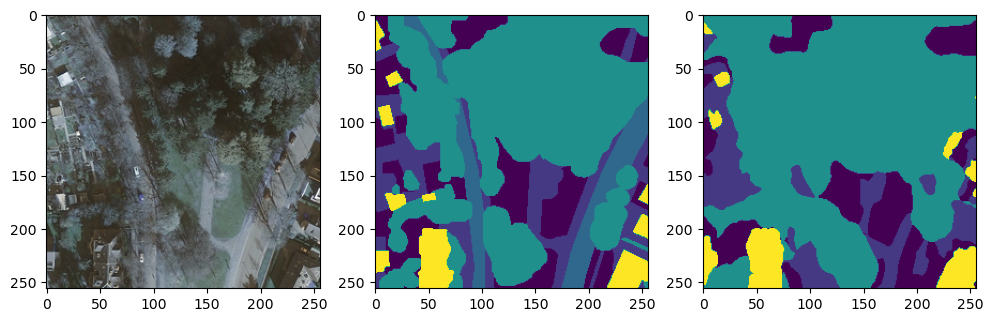

In [17]:
pred_img_path = sorted(glob('/home/ubuntu/hrl/high-res-lulc/data/processing/images/aachen*.png'))[54]
viz_data(pred_img_path)

In [11]:
import numpy as np
import hvplot.xarray
import xarray as xr

In [8]:
def viz_data(image_pth):
    img = imread(image_pth)
    img_da = xr.DataArray(img, name='image')
    image_plot = img_da.hvplot.image()
    img_list = glob(image_pth)
    predict_loader = DataLoader(OEMDataset(img_list), batch_size=1)
    preds = pred_labels(trainer=trainer, dataloader=predict_loader)
    pred_da = xr.DataArray(preds, name='Pred')
    pred_plot = pred_da.hvplot.image()
    plt.rcParams["figure.figsize"] = (12,4)
    try:
        label = imread(image_pth.replace('/images/', '/labels/'))
        label_da = xr.DataArray(label, name='image')
        label_plot = label_da.hvplot.image()
        pl, pc= np.unique(preds, return_counts=True)
        al, ac= np.unique(label, return_counts=True)

        print(f'Pred Labels found: {pl}')
        np.set_printoptions(precision=3, suppress=True)
        print(f'Pred percentages: {pc/np.sum(pc)*100}')
        print(f'Actual Labels found: {al}')
        np.set_printoptions(precision=3, suppress=True)
        print(f'Pred percentages: {ac/np.sum(ac)*100}')

        combined_plot = image_plot*label_plot*pred_plot
        combined_plot
        
    except:
        pl, pc= np.unique(preds, return_counts=True)
        combined_plot = image_plot*pred_plot
        # f, imx = plt.subplots(1,2)
        # imx[0].imshow(img)
        # imx[1].imshow(preds)
        print(f'Pred Labels found: {pl}')
        np.set_printoptions(precision=3, suppress=True)
        print(f'Label percentages: {pc/np.sum(pc)*100}')
        combined_plot


In [9]:
pred_img_path = sorted(glob('/home/ubuntu/hrl/high-res-lulc/data/processing/images/aachen*.png'))[44]
viz_data(pred_img_path)

DataError: The coordinates on the 'image' DataArray do not match the provided key dimensions (kdims). The following coords were left unspecified: ['dim_0']. If you are requesting a lower dimensional view such as a histogram cast the xarray to a columnar format using the .to_dataframe or .to_dask_dataframe methods before providing it to HoloViews.